In [5]:
#Notebook 02 — EDA: Sales & Prices
#🎯 Objetivo del notebook
#Transformar ventas wide → long
#Unir: Ventas, Precios, Calendario
#Crear métricas clave: Revenue, Precio promedio.
#Generar primeros insights de elasticidad

In [25]:
#Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [26]:
#Cargar datos procesados del Notebook 01

sales = pd.read_csv("sales_subset_raw.csv")
calendar = pd.read_csv("calendar_clean.csv")
prices = pd.read_csv("sell_prices_clean.csv")

calendar['date'] = pd.to_datetime(calendar['date'])

In [27]:
# --- Optimización de dtypes ---
cat_cols = ['id','item_id','dept_id','store_id','state_id','cat_id']
for c in cat_cols:
    sales[c] = sales[c].astype('category')

In [28]:
# --- Limitar ventana temporal para evitar explotar memoria ---
# Ejemplo: últimos 365 días disponibles
d_cols = [c for c in sales.columns if c.startswith("d_")]
last_n_days = 365
d_cols_keep = d_cols[-last_n_days:]

keep_cols = ['id','item_id','dept_id','store_id','state_id','cat_id'] + d_cols_keep
sales = sales[keep_cols].copy()

print("New sales shape (reduced days):", sales.shape)
print("Expected rows after melt:", f"{len(sales)*len(d_cols_keep):,}")

New sales shape (reduced days): (12390, 371)
Expected rows after melt: 4,522,350


In [29]:
# --- Guardrails: tamaño antes del melt ---
d_cols = [c for c in sales.columns if c.startswith("d_")]
print("sales shape:", sales.shape)
print("# d_cols:", len(d_cols))

expected_rows = len(sales) * len(d_cols)
print("Expected rows after melt:", f"{expected_rows:,}")

# Regla práctica: arriba de 5-8M filas en laptop suele romper el kernel

sales shape: (12390, 371)
# d_cols: 365
Expected rows after melt: 4,522,350


In [30]:
#Transformar ventas (wide-> long)

id_vars = ['id','item_id','dept_id','store_id','state_id','cat_id']
sales_long = sales.melt(
    id_vars=id_vars,
    var_name='d',
    value_name='units_sold'
)

print("sales_long shape:", sales_long.shape)
print("sales_long memory (MB):", sales_long.memory_usage(deep=True).sum() / 1024**2)

sales_long shape: (4522350, 8)
sales_long memory (MB): 307.4750337600708


In [31]:
#Chequeo
sales_long.head()
sales_long.shape

(4522350, 8)

In [32]:
# downcast de units_sold
sales_long['units_sold'] = pd.to_numeric(sales_long['units_sold'], downcast='integer')


In [33]:
# Asegura datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Filtra calendar solo a los d's usados
calendar_small = calendar[calendar['d'].isin(sales_long['d'].unique())][['d','date','wm_yr_wk']].copy()


In [34]:
#Join con calendario

sales_long = sales_long.merge(calendar_small, on='d', how='left')


In [35]:
#Validación
sales_long.isna().sum()

id            0
item_id       0
dept_id       0
store_id      0
state_id      0
cat_id        0
d             0
units_sold    0
date          0
wm_yr_wk      0
dtype: int64

In [36]:
# Filtra prices solo a stores/items presentes (reduce mucho)
valid_stores = sales_long['store_id'].unique()
valid_items  = sales_long['item_id'].unique()

prices_small = prices[
    prices['store_id'].isin(valid_stores) &
    prices['item_id'].isin(valid_items)
].copy()

# Opcional: dtype de store_id/item_id a category también
prices_small['store_id'] = prices_small['store_id'].astype('category')
prices_small['item_id'] = prices_small['item_id'].astype('category')

In [37]:
#Join con precios

sales_long = sales_long.merge(
    prices_small,
    on=['store_id','item_id','wm_yr_wk'],
    how='left'
)

In [38]:
#Liberar dataframe "Sales" debido a su tamaño

del sales
import gc
gc.collect()


0

In [39]:
#Chequeo
sales_long[['sell_price']].isna().mean()

sell_price    0.001237
dtype: float64

In [40]:
#Fuerza dtypes en sell_price y wm_yr_wk (reduce RAM y evita merges raros)

calendar['wm_yr_wk'] = pd.to_numeric(calendar['wm_yr_wk'], downcast='integer')
prices['wm_yr_wk'] = pd.to_numeric(prices['wm_yr_wk'], downcast='integer')
prices['sell_price'] = pd.to_numeric(prices['sell_price'], downcast='float')

In [ ]:
#País ficticio (estrategia de simulación)

In [41]:
# Diccionario mapeando IDs de estado a sus países correspondientes
country_map = {'CA':'US', 'TX':'MX', 'WI':'ES'}
sales_long['country'] = sales_long['state_id'].map(country_map)

sales_long['revenue'] = sales_long['units_sold'] * sales_long['sell_price']

eda_df = sales_long.dropna(subset=['sell_price'])
eda_df = eda_df[eda_df['units_sold'] > 0].copy()

print("eda_df shape:", eda_df.shape)

eda_df.to_parquet("eda_sales_prices.parquet", index=False)

eda_df shape: (1999645, 13)


In [ ]:
#Limpieza final para EDA

In [42]:
#Quitamos
#Días sin precio
#Ventas=0 (para elasticidad)

eda_df= sales_long.dropna(subset=['sell_price'])

In [43]:
#Chequeo

eda_df.shape

(4516758, 13)

In [ ]:
#EDA Clave orientado a pricing

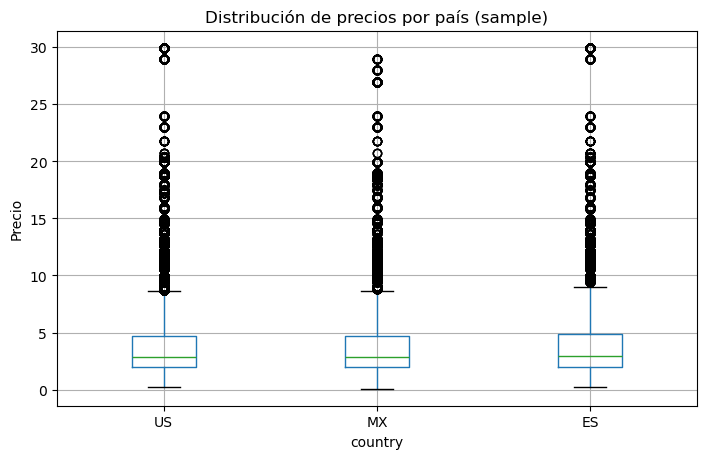

In [44]:
#Distribución de precios por país

plot_df = eda_df.sample(min(len(eda_df), 200_000), random_state=42)

plot_df.boxplot(column='sell_price', by='country', figsize=(8,5))
plt.title("Distribución de precios por país (sample)")

plt.suptitle("")
plt.ylabel("Precio")
plt.show()


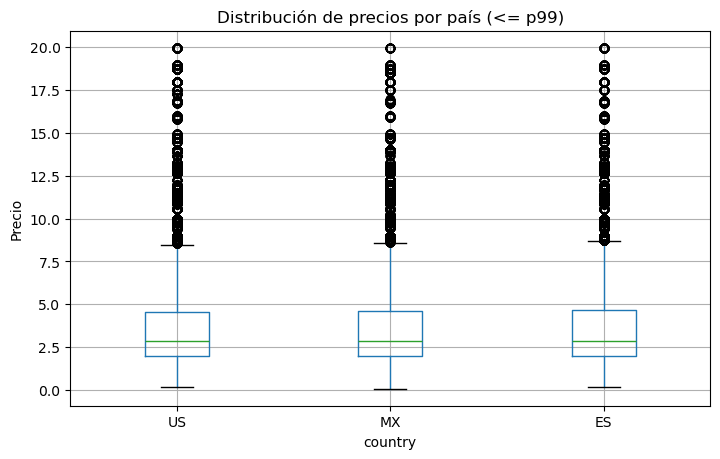

In [45]:
#Mejora de gráfico sin outliers.
plot_df2 = plot_df.copy()
p99 = plot_df2['sell_price'].quantile(0.99)
plot_df2 = plot_df2[plot_df2['sell_price'] <= p99]

plot_df2.boxplot(column='sell_price', by='country', figsize=(8,5))
plt.title("Distribución de precios por país (<= p99)")
plt.suptitle("")
plt.ylabel("Precio")
plt.show()
